In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
import os

tf.random.set_seed(42)
np.random.seed(42)

In [6]:
class BeanCNNClassifier:
    def __init__(self, img_size=(224, 224), num_classes=3):
        self.img_size = img_size
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def load_and_preprocess_dataset(self):
        print("Loading beans dataset from Hugging Face...")

        dataset = load_dataset("AI-Lab-Makerere/beans")

        self.class_names = dataset['train'].features['labels'].names
        print(f"Classes: {self.class_names}")

        train_images, train_labels = self._process_split(dataset['train'])
        val_images, val_labels = self._process_split(dataset['validation'])
        test_images, test_labels = self._process_split(dataset['test'])

        print(f"Training samples: {len(train_images)}")
        print(f"Validation samples: {len(val_images)}")
        print(f"Test samples: {len(test_images)}")

        return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

    def _process_split(self, split):
        images = []
        labels = []

        for item in split:
            img = item['image']
            if img.mode != 'RGB':
                img = img.convert('RGB')

            img = img.resize(self.img_size)
            img_array = np.array(img) / 255.0

            images.append(img_array)
            labels.append(item['labels'])

        return np.array(images), np.array(labels)

    def build_cnn_model(self):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=(*self.img_size, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train_model(self, train_data, val_data, epochs=50, batch_size=32):
        train_images, train_labels = train_data
        val_images, val_labels = val_data

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        model_checkpoint = ModelCheckpoint(
            'best_bean_cnn_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )

        callbacks = [early_stopping, model_checkpoint]

        print("Starting training...")
        self.history = self.model.fit(
            train_images, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(val_images, val_labels),
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate_model(self, test_data):
        test_images, test_labels = test_data

        test_loss, test_accuracy = self.model.evaluate(
            test_images, test_labels, verbose=0
        )

        print(f"\nTest Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

        return test_loss, test_accuracy

    def plot_training_history(self):
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def print_model_summary(self):
        if self.model is None:
            print("Model not built yet. Call build_cnn_model() first.")
            return

        print("\nModel Architecture:")
        print("=" * 50)
        self.model.summary()

    def get_training_report(self):
        if self.history is None:
            print("No training history available.")
            return

        final_train_acc = self.history.history['accuracy'][-1]
        final_val_acc = self.history.history['val_accuracy'][-1]
        final_train_loss = self.history.history['loss'][-1]
        final_val_loss = self.history.history['val_loss'][-1]

        best_val_acc = max(self.history.history['val_accuracy'])
        best_val_acc_epoch = self.history.history['val_accuracy'].index(best_val_acc) + 1

        print("\n" + "="*60)
        print("TRAINING REPORT")
        print("="*60)
        print(f"Total Epochs Trained: {len(self.history.history['accuracy'])}")
        print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_val_acc_epoch})")
        print("\nFinal Epoch Metrics:")
        print(f"  Training Accuracy: {final_train_acc:.4f}")
        print(f"  Validation Accuracy: {final_val_acc:.4f}")
        print(f"  Training Loss: {final_train_loss:.4f}")
        print(f"  Validation Loss: {final_val_loss:.4f}")
        print("="*60)

In [7]:
!pip install --upgrade datasets

Bean Leaf Disease Classification - Baseline CNN
Loading beans dataset from Hugging Face...
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
Training samples: 1034
Validation samples: 133
Test samples: 128

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,395,395 (73.99 MB)

 Trainable params: 19,395,395 (73.99 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3158 - loss: 1.4492
Epoch 1: val_accuracy improved from -inf to 0.39098, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.3167 - loss: 1.4424 - val_accuracy: 0.3910 - val_loss: 1.0763
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4567 - loss: 1.0373
Epoch 2: val_accuracy improved from 0.39098 to 0.56391, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4581 - loss: 1.0355 - val_accuracy: 0.5639 - val_loss: 0.9554
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5135 - loss: 0.9583
Epoch 3: val_accuracy improved from 0.56391 to 0.63910, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.5150 - loss: 0.9566 - val_accuracy: 0.6391 - val_loss: 0.7900
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6088 - loss: 0.8670
Epoch 4: val_accuracy improved from 0.63910 to 0.71429, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.6097 - loss: 0.8653 - val_accuracy: 0.7143 - val_loss: 0.6763
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6482 - loss: 0.8036
Epoch 5: val_accuracy did not improve from 0.71429
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.6494 - loss: 0.8019 - val_accuracy: 0.7143 - val_loss: 0.6661
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6738 - loss: 0.7581
Epoch 6: val_accuracy improved from 0.71429 to 0.74436, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.6748 - loss: 0.7563 - val_accuracy: 0.7444 - val_loss: 0.5999
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6801 - loss: 0.7127
Epoch 7: val_accuracy improved from 0.74436 to 0.75188, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.6807 - loss: 0.7117 - val_accuracy: 0.7519 - val_loss: 0.6230
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6962 - loss: 0.6683
Epoch 8: val_accuracy did not improve from 0.75188
33/33 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.6965 - loss: 0.6674 - val_accuracy: 0.7519 - val_loss: 0.5376
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6868 - loss: 0.6531
Epoch 9: val_accuracy improved from 0.75188 to 0.77444, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.6873 - loss: 0.6522 - val_accuracy: 0.7744 - val_loss: 0.5254
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7173 - loss: 0.6178
Epoch 10: val_accuracy did not improve from 0.77444
33/33 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.7184 - loss: 0.6162 - val_accuracy: 0.7519 - val_loss: 0.5039
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7275 - loss: 0.5906
Epoch 11: val_accuracy did not improve from 0.77444
33/33 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7282 - loss: 0.5895 - val_accuracy: 0.7368 - val_loss: 0.5171
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7727 - loss: 0.5156
Epoch 12: val_accuracy improved from 0.77444 to 0.78195, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.7733 - loss: 0.5146 - val_accuracy: 0.7820 - val_loss: 0.5415
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8030 - loss: 0.4460
Epoch 13: val_accuracy did not improve from 0.78195
33/33 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8040 - loss: 0.4447 - val_accuracy: 0.7820 - val_loss: 0.5051
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7861 - loss: 0.5163
Epoch 14: val_accuracy improved from 0.78195 to 0.80451, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.7871 - loss: 0.5137 - val_accuracy: 0.8045 - val_loss: 0.4885
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8406 - loss: 0.3717
Epoch 15: val_accuracy improved from 0.80451 to 0.82707, saving model to best_bean_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8412 - loss: 0.3709 - val_accuracy: 0.8271 - val_loss: 0.4223
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8246 - loss: 0.4097
Epoch 16: val_accuracy did not improve from 0.82707
33/33 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.8252 - loss: 0.4087 - val_accuracy: 0.7895 - val_loss: 0.5063
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8407 - loss: 0.3963
Epoch 17: val_accuracy did not improve from 0.82707
33/33 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.8409 - loss: 0.3954 - val_accuracy: 0.7744 - val_loss: 0.5320
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8572 - loss: 0.3609
Epoch 18: val_accuracy did not improve from 0.82707
33/33 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.8583 - loss: 0.3590 - val_accuracy: 0.8271 - val_loss: 0.5313
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9287 - loss: 0.2286
Epoch 19: val_accuracy did not improve from 

33/33 ━━━━━━━━━━━━━━━━━━━━ 210s 5s/step - accuracy: 0.9503 - loss: 0.1524 - val_accuracy: 0.8647 - val_loss: 0.5192
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9509 - loss: 0.1125
Epoch 23: val_accuracy did not improve from 0.86466
33/33 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9511 - loss: 0.1125 - val_accuracy: 0.8271 - val_loss: 0.6103
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9465 - loss: 0.1388
Epoch 24: val_accuracy did not improve from 0.86466
33/33 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.9469 - loss: 0.1382 - val_accuracy: 0.8271 - val_loss: 0.6168
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9642 - loss: 0.1108
Epoch 25: val_accuracy did not improve from 0.86466
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9641 - loss: 0.1108 - val_accuracy: 0.7744 - val_loss: 0.7844
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.

TRAINING REPORT
Total Epochs Trained: 25
B

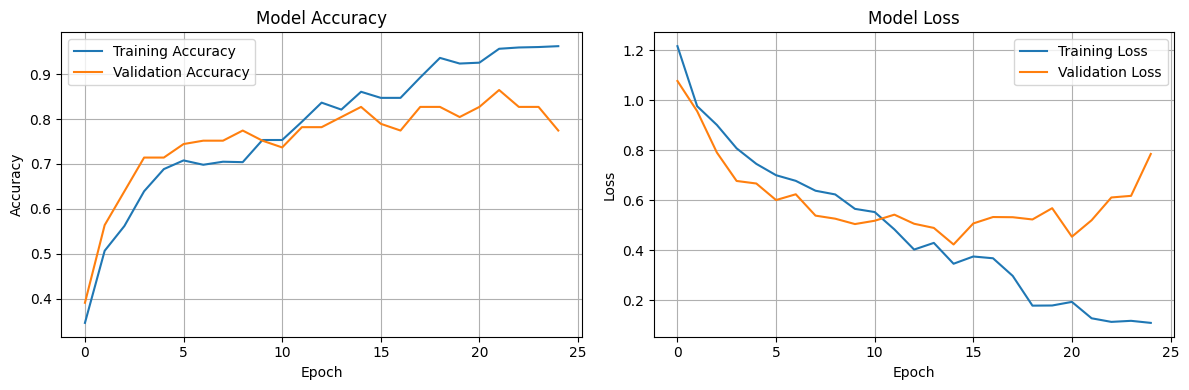


Training completed! Model saved as 'best_bean_cnn_model.h5'
Training history plot saved as 'training_history.png'


In [8]:
def main():
    print("Bean Leaf Disease Classification - Baseline CNN")
    print("="*50)

    classifier = BeanCNNClassifier(img_size=(224, 224), num_classes=3)

    train_data, val_data, test_data = classifier.load_and_preprocess_dataset()

    model = classifier.build_cnn_model()
    classifier.print_model_summary()

    history = classifier.train_model(
        train_data, val_data,
        epochs=50,
        batch_size=32
    )

    classifier.get_training_report()

    classifier.evaluate_model(test_data)

    classifier.plot_training_history()

    print("\nTraining completed! Model saved as 'best_bean_cnn_model.h5'")
    print("Training history plot saved as 'training_history.png'")

if __name__ == "__main__":
    main()